In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización de datos
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.ensemble import RandomForestRegressor

#from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
import matplotlib

# Parámetros de matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'large'
matplotlib.rcParams["font.family"] = "serif"

In C:\Users\miche\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\miche\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\miche\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Random Forest Regressor 


In [2]:
data = pd.read_csv("./primary_dataset_v6.csv", index_col = 0)
data_desc = pd.read_csv("primary_dataset_v6_descr.csv",index_col=0)

data.describe()


value = data.select_dtypes(include = "number")
IV = (value["ICA"]+value["IDA"])/2

# Creación de Test-Train-set (Es importante que queden bien estratificados, por lo tanto ver el archivo). 

coord=value['longitud'].apply(str)+value['latitud'].apply(str)
coord
value['coord']=coord
value['IV'] = IV

MSE = []
R2 = []
MAE = []
best_model = dict()


# Train-set
for _ in range(20):

    unique_data = value['coord'].unique()
    values_train = np.random.choice(unique_data, int(len(unique_data)*0.80),False)
    train = value[value['coord'].isin(values_train)]

# Train-test

    values_test = set(unique_data)- set(values_train) 
    test = value[value['coord'].isin(values_test)]

# variables predictoras y no predictoras

    values_non_pred = ["n_tot","so4_tot", "na_tot", "k_tot", "sio2", "ca_tot", "mg_tot", "alc_tot",
                    "hco3", "n_no2", "p_tot", "cloruros_tot", "po4_tot", "n_nh3","n_totk", "co3", "ss_uso_tot","ss_cp",
                    'ss_cg','visibility','daily_visibility','ozone','daily_ozone',"time"]+[col for col in data if 'time' in col] + [col for col in data if 'wind' in col]+ [col for col in data if 'moon' in col]
    values_pred= ['IV','IDA','ICA','coord','año','time','longitud','latitud']

# clasificacion x,y train 

    xtrain  = train.drop(values_non_pred+ values_pred,axis =1)
    ytrain = train['IV']

# clasificacion x,y test

    xtest  = test.drop(values_non_pred+ values_pred,axis =1)
    ytest = test['IV']

    xtrain=xtrain.fillna(-100)
    xtest=xtest.fillna(-100)

    RFR= RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=None,min_samples_split =2,min_samples_leaf =1)
    RFR.fit(xtrain,ytrain)
    ypred = RFR.predict(xtest)
    MSE.append(mean_squared_error(ytest,ypred))
    R2.append(r2_score(ytest,ypred))
    MAE.append(mean_absolute_error(ytest,ypred))
    
    if len(R2)>=2:
        if R2[-1]>R2[-2]:
            best_model['model'] = RFR
            best_model['xtest'] = xtest
            best_model['ytest'] = ytest
    else:
        best_model['model'] = RFR
        best_model['xtest'] = xtest
        best_model['ytest'] = ytest
            
            
    
    



C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [3]:
import shap
x_test = best_model['xtest']
explainer = shap.TreeExplainer(RFR)
shap_values = explainer.shap_values(x_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


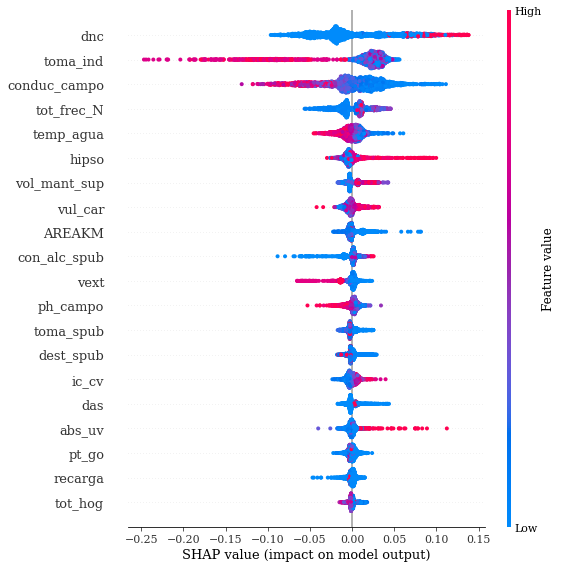

In [4]:
shap.summary_plot(shap_values,x_test)

In [5]:
# mean_squared_error(ytest,ypred)
# print("Error promedio cuadrado:",mean_squared_error(ytest,ypred))
# print("Valor R2:", r2_score(ytest,ypred))
# print("Error promedio absoluto:",mean_absolute_error(ytest,ypred))

In [6]:
# plt.scatter(ypred,ytest)
# #for y= c0 + c1x 
# #XX = np.arange(0.0, 10.0, 0.1)
# #yy =  RFR.intercept_[0]+ RFR.coef_[0][1]*XX
# plt.title("Correlacion entre valores reales y valores predictivos")
# plt.xlabel("Valores reales")
# plt.ylabel("Valores predictivos")

In [7]:
importancia = pd.DataFrame(RFR.feature_importances_)
columnas = pd.DataFrame(xtrain.columns)
columnas ["importancia"] = importancia
sort = columnas.sort_values('importancia',ascending = False)

## Validación del modelo

In [8]:
print("Validación del modelo:", RFR.score(xtest,ytest))

Validación del modelo: 0.29440599964323355


## Visualización

Text(0, 0.5, 'R2')

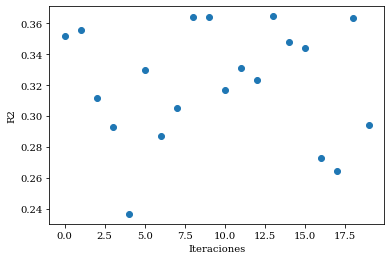

In [16]:
plt.scatter(range(0,20),R2)
plt.xlabel("Iteraciones")
plt.ylabel("R2")


Text(0, 0.5, 'MEA')

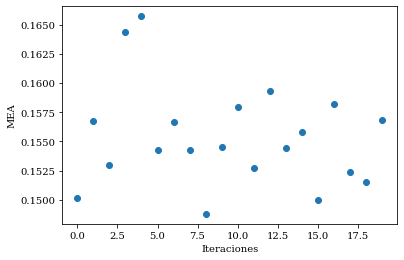

In [20]:
plt.scatter(range(20),MAE)
plt.xlabel("Iteraciones")
plt.ylabel("MEA")

Text(0, 0.5, 'MSE')

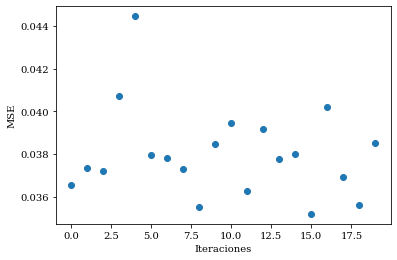

In [21]:
plt.scatter(range(20),MSE)
plt.xlabel("Iteraciones")
plt.ylabel("MSE")

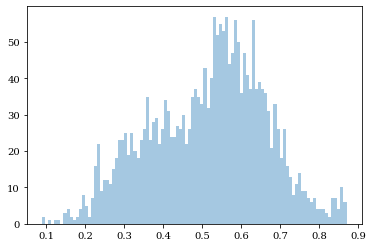

In [23]:
sns.distplot(ypred,bins = 100,kde = False)

Text(0.5, 1.0, 'Importancia de los parámetros')

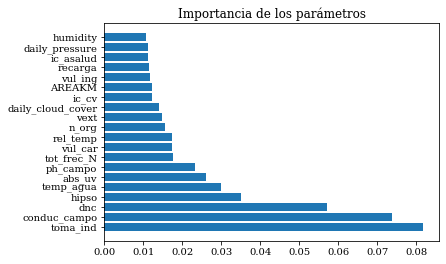

In [28]:
plt.barh(sort[0].iloc[0:20],sort['importancia'].iloc[0:20])
plt.title("Importancia de los parámetros")


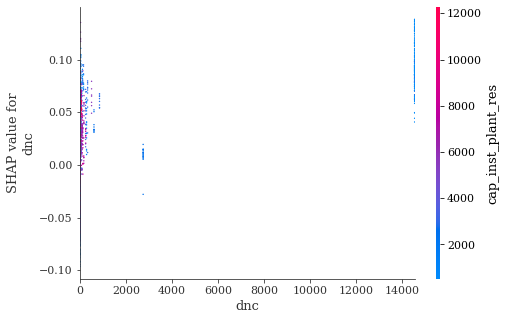

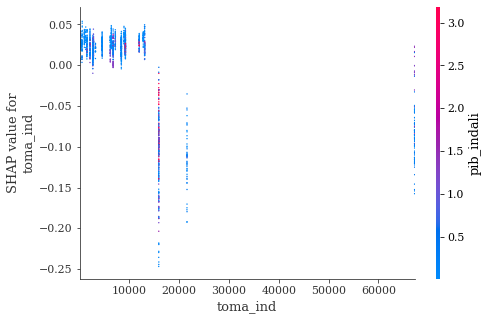

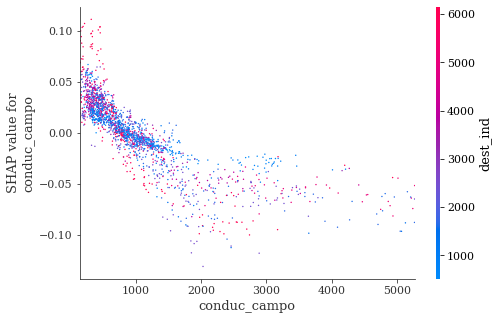

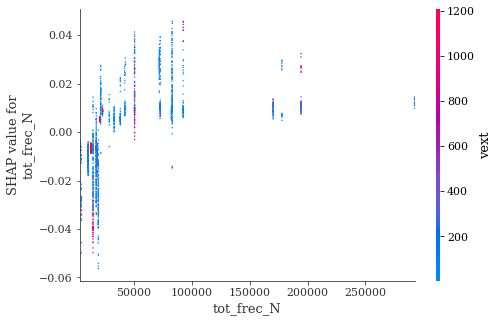

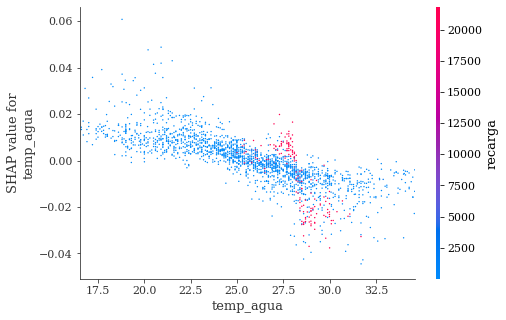

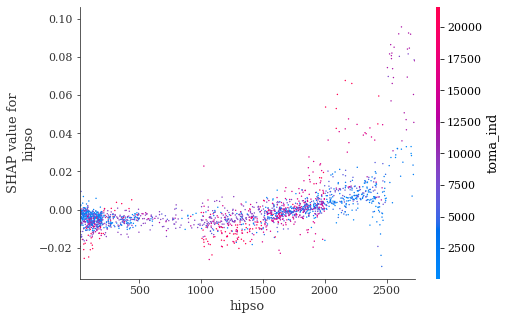

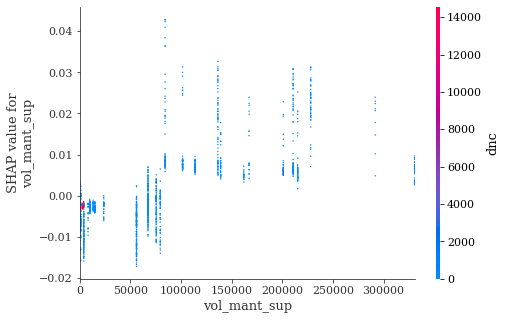

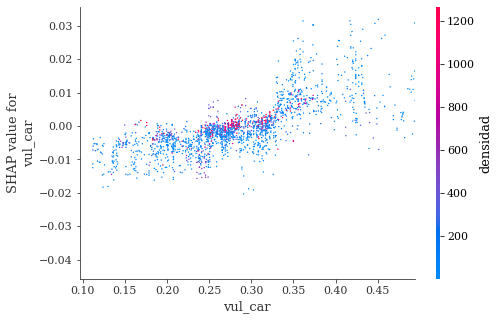

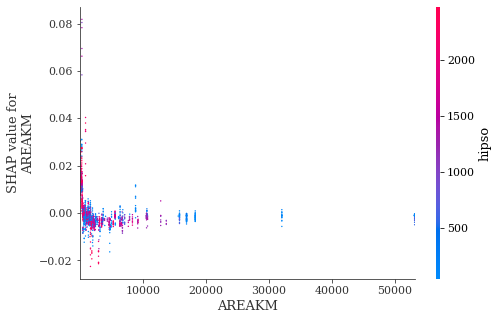

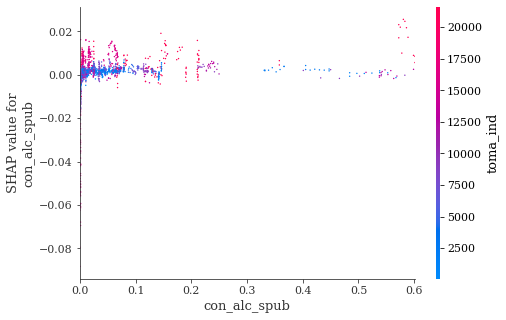

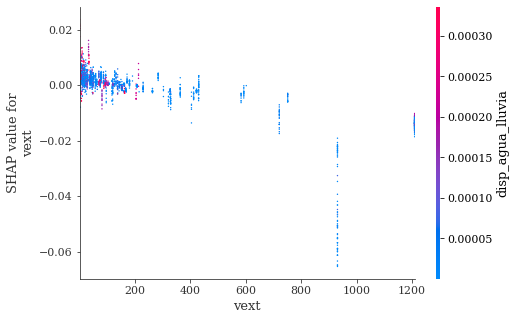

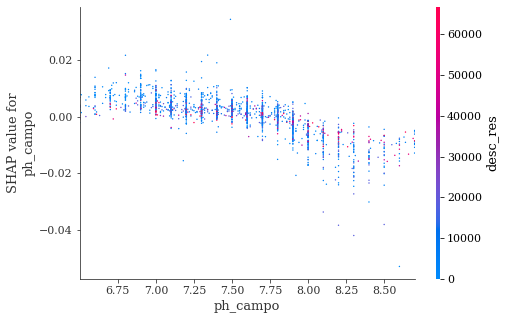

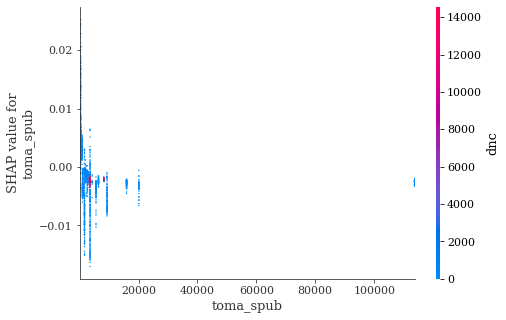

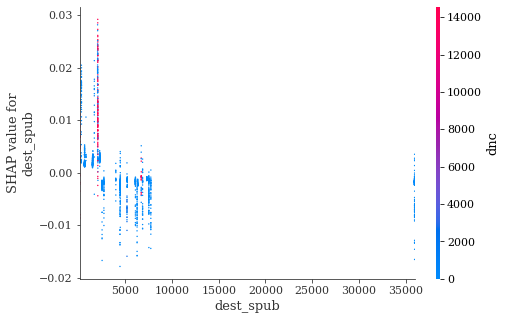

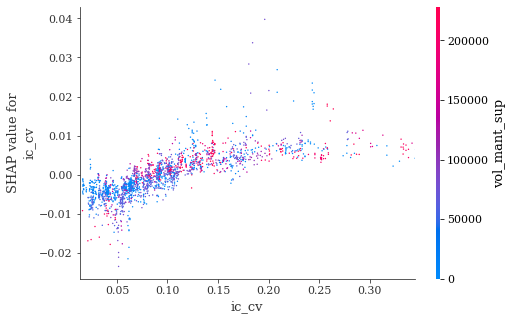

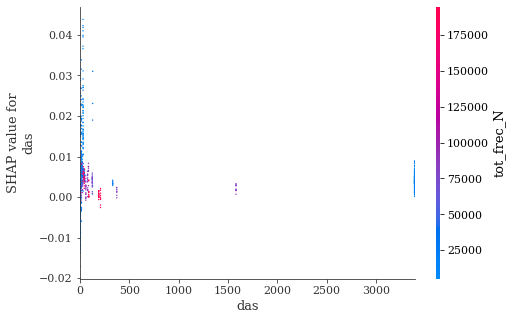

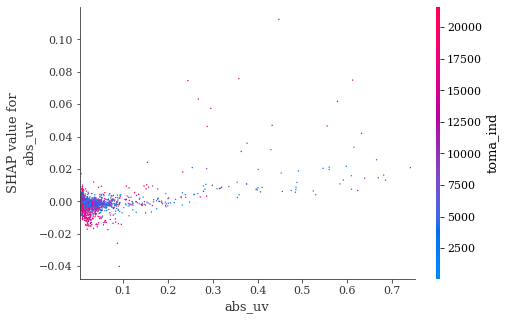

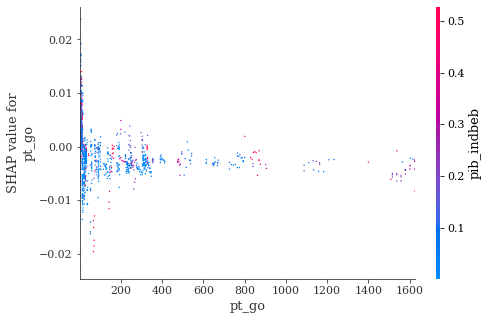

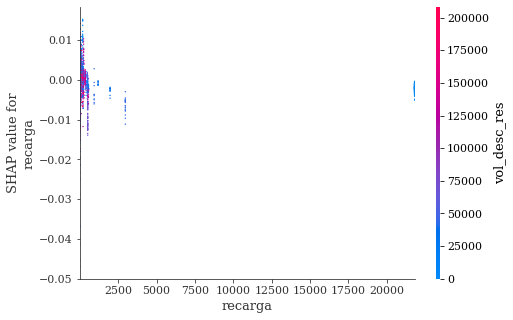

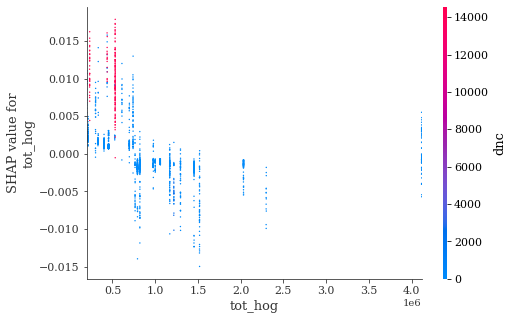

In [26]:
top_ind = np.argsort(-np.sum(np.abs(shap_values),0))

for i in range(20):
    shap.dependence_plot(top_ind[i],shap_values,x_test,xmin ='percentile(2)',xmax='percentile(98)',dot_size =2,x_jitter = 1 )